### Import lib

In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import models.seg as sm
from Data import Data_train, Data_eval
from include.loss import pixel_weighted_cross_entropy
from saver import Saver
from include.generators import Generator

import model_eval
import wandb
from wandb.keras import WandbCallback

2023-02-07 16:08:29.239689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/cerea_raid/users/dumontj/dev/coco2/dl


### GPU Memory

In [11]:
gpu_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [12]:
tf.config.experimental.get_memory_info("GPU:0")["peak"] / 1e6

0.0

### Data download

In [23]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip/2d_train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/2d_valid_dataset.nc"
path_eval_nc = path_valid_nc

save_dir = "/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/test"

In [24]:
chan_1 = "xco2"
chan_2 = "no2"
chan_3 = "None"
chan_4 = "None"

In [25]:
data = Data_train(
    path_train_nc,
    path_valid_nc,
)
data.prepare_input(chan_1, chan_2, chan_3, chan_4)

data.prepare_output_segmentation(max_w=1)

data.x.train.shape (37734, 64, 64, 2)
data.y.train.shape (37734, 64, 64, 1)


### Generator

In [26]:
generator = Generator("segmentation", 32, 90, 0.2, True, 45, 0.2, shuffle=True)

### Model def

In [27]:
seg_builder = sm.Seg_model_builder(
    "Unet_efficientnetb0", data.x.fields_input_shape, data.y.classes
)
model = seg_builder.get_model()
model.compile("adam", loss=pixel_weighted_cross_entropy)

EfficientNetB0 [64, 64, 2] 1


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/applications/efficientnet.py:321: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
wandb: Waiting for W&B process to finish... (success).


### Training

In [20]:
modelcheckpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir, "best_w.h5"),
    save_weights_only=False,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)
callbacks = [modelcheckpoint_cb]

In [21]:
wandb.init()
callbacks = [modelcheckpoint_cb, WandbCallback()]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▆▄▅▃▄▄▃▃▂▂▃▁▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▂▂▂▁▂▁▂
best_epoch,69
best_val_loss,0.11756
epoch,99
loss,0.0854
val_loss,0.13129


### fit

In [22]:
model.fit(
    generator.flow(data.x.train, data.y.train),
    epochs=100,
    validation_data=(data.x.valid, data.y.valid),
    callbacks=callbacks,
    steps_per_epoch=int(np.floor(data.x.train.shape[0] / 32)),
)

Epoch 1/100


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (6289, 64, 64, 2) (2 channels).
  warnings.warn(
2023-02-07 16:41:00.603014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


196/196 [==============================] - ETA: 0s - loss: 0.1923

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 71s 231ms/step - loss: 0.1923 - val_loss: 0.1944
Epoch 2/100
196/196 [==============================] - ETA: 0s - loss: 0.1537

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 42s 213ms/step - loss: 0.1537 - val_loss: 0.1905
Epoch 3/100
196/196 [==============================] - ETA: 0s - loss: 0.1453

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.7s


196/196 [==============================] - 42s 214ms/step - loss: 0.1453 - val_loss: 0.1687
Epoch 4/100
196/196 [==============================] - ETA: 0s - loss: 0.1399

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 43s 219ms/step - loss: 0.1399 - val_loss: 0.1441
Epoch 5/100
196/196 [==============================] - 11s 56ms/step - loss: 0.1343 - val_loss: 0.1474
Epoch 6/100
196/196 [==============================] - 11s 58ms/step - loss: 0.1307 - val_loss: 0.1481
Epoch 7/100
196/196 [==============================] - ETA: 0s - loss: 0.1283

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 45s 230ms/step - loss: 0.1283 - val_loss: 0.1381
Epoch 8/100
196/196 [==============================] - 11s 57ms/step - loss: 0.1253 - val_loss: 0.1414
Epoch 9/100
196/196 [==============================] - ETA: 0s - loss: 0.1201

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 42s 215ms/step - loss: 0.1201 - val_loss: 0.1313
Epoch 10/100
196/196 [==============================] - ETA: 0s - loss: 0.1174

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 42s 213ms/step - loss: 0.1174 - val_loss: 0.1248
Epoch 11/100
196/196 [==============================] - ETA: 0s - loss: 0.1147

INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/dl/wandb/run-20230207_164039-1nqgw3ai/files/model-best)... Done. 2.4s


196/196 [==============================] - 43s 222ms/step - loss: 0.1147 - val_loss: 0.1166
Epoch 12/100
196/196 [==============================] - 11s 57ms/step - loss: 0.1149 - val_loss: 0.1278
Epoch 13/100
196/196 [==============================] - 12s 59ms/step - loss: 0.1125 - val_loss: 0.1217
Epoch 14/100
  9/196 [>.............................] - ETA: 9s - loss: 0.1114


KeyboardInterrupt



### fit no gen

In [89]:
model.fit(
    x=data.x.train,
    y=data.y.train,
    epochs=10,
    validation_data=(data.x.valid, data.y.valid),
    callbacks=[modelcheckpoint_cb],
)

Epoch 1/10


2023-01-30 15:22:20.862623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1180/1180 [==============================] - 96s 60ms/step - loss: 0.6527 - val_loss: 0.6424
Epoch 2/10
1180/1180 [==============================] - 69s 58ms/step - loss: 0.5371 - val_loss: 0.6492
Epoch 3/10
1180/1180 [==============================] - 69s 58ms/step - loss: 0.4789 - val_loss: 0.6890
Epoch 4/10
1180/1180 [==============================] - 70s 59ms/step - loss: 0.4415 - val_loss: 0.6026
Epoch 5/10
1180/1180 [==============================] - 68s 58ms/step - loss: 0.4112 - val_loss: 0.7125
Epoch 6/10
1180/1180 [==============================] - 68s 58ms/step - loss: 0.3880 - val_loss: 0.6679
Epoch 7/10
1180/1180 [==============================] - 68s 58ms/step - loss: 0.3674 - val_loss: 0.7452
Epoch 8/10
  23/1180 [..............................] - ETA: 1:09 - loss: 0.3251

KeyboardInterrupt: 

### Save model

In [35]:
model.save(os.path.join(save_dir, "last.h5"))
joblib.dump(data.x.scaler, os.path.join(save_dir, "scaler.save"))

['/cerea_raid/users/dumontj/dev/coco2/dl/nb_train/sim/test/scaler.save']

## Evaluation

In [7]:
data = Data_eval(path_eval_nc)
data.prepare_input(model_eval.get_scaler(save_dir), chan_1, chan_2, chan_3, chan_4)
data.prepare_output_segmentation(max_w=1)
model = model_eval.get_segmentation_model(os.path.join(save_dir), name_w="best_w.h5")

data.x.eval.shape (1152, 64, 64, 4)
data.y.train.shape (1152, 64, 64, 1)


2023-02-07 14:51:57.686215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 14:51:58.203024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14516 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [38]:
wbce = model_eval.get_wbce_model_on_data(model, data)
print(np.mean(wbce))

36/36 [==============================] - 2s 14ms/step
0.1735624


In [39]:
nwbce = model_eval.get_nwbce_model_on_data(model, data)
print(np.mean(nwbce))

36/36 [==============================] - 1s 14ms/step
0.77066356


nwbce: 0.42075863
idx 934
origin: smart_2km_Lip_64
time: 2015-10-21T22:00:00.000000000
emiss: [15.5099  16.31799 16.47991 16.48003 16.80334 17.28848]
nwbce: 0.42253503
idx 614
origin: smart_2km_Lip_64
time: 2015-07-07T14:00:00.000000000
emiss: [15.78407 15.922   16.19874 16.75243 16.75226 16.8906 ]
nwbce: 1.0969491
idx 577
origin: smart_2km_Lip_64
time: 2015-07-06T01:00:00.000000000
emiss: [ 9.967428 10.93639   9.286618 10.13091  10.65884  10.76465 ]


<Figure size 1920x1440 with 0 Axes>

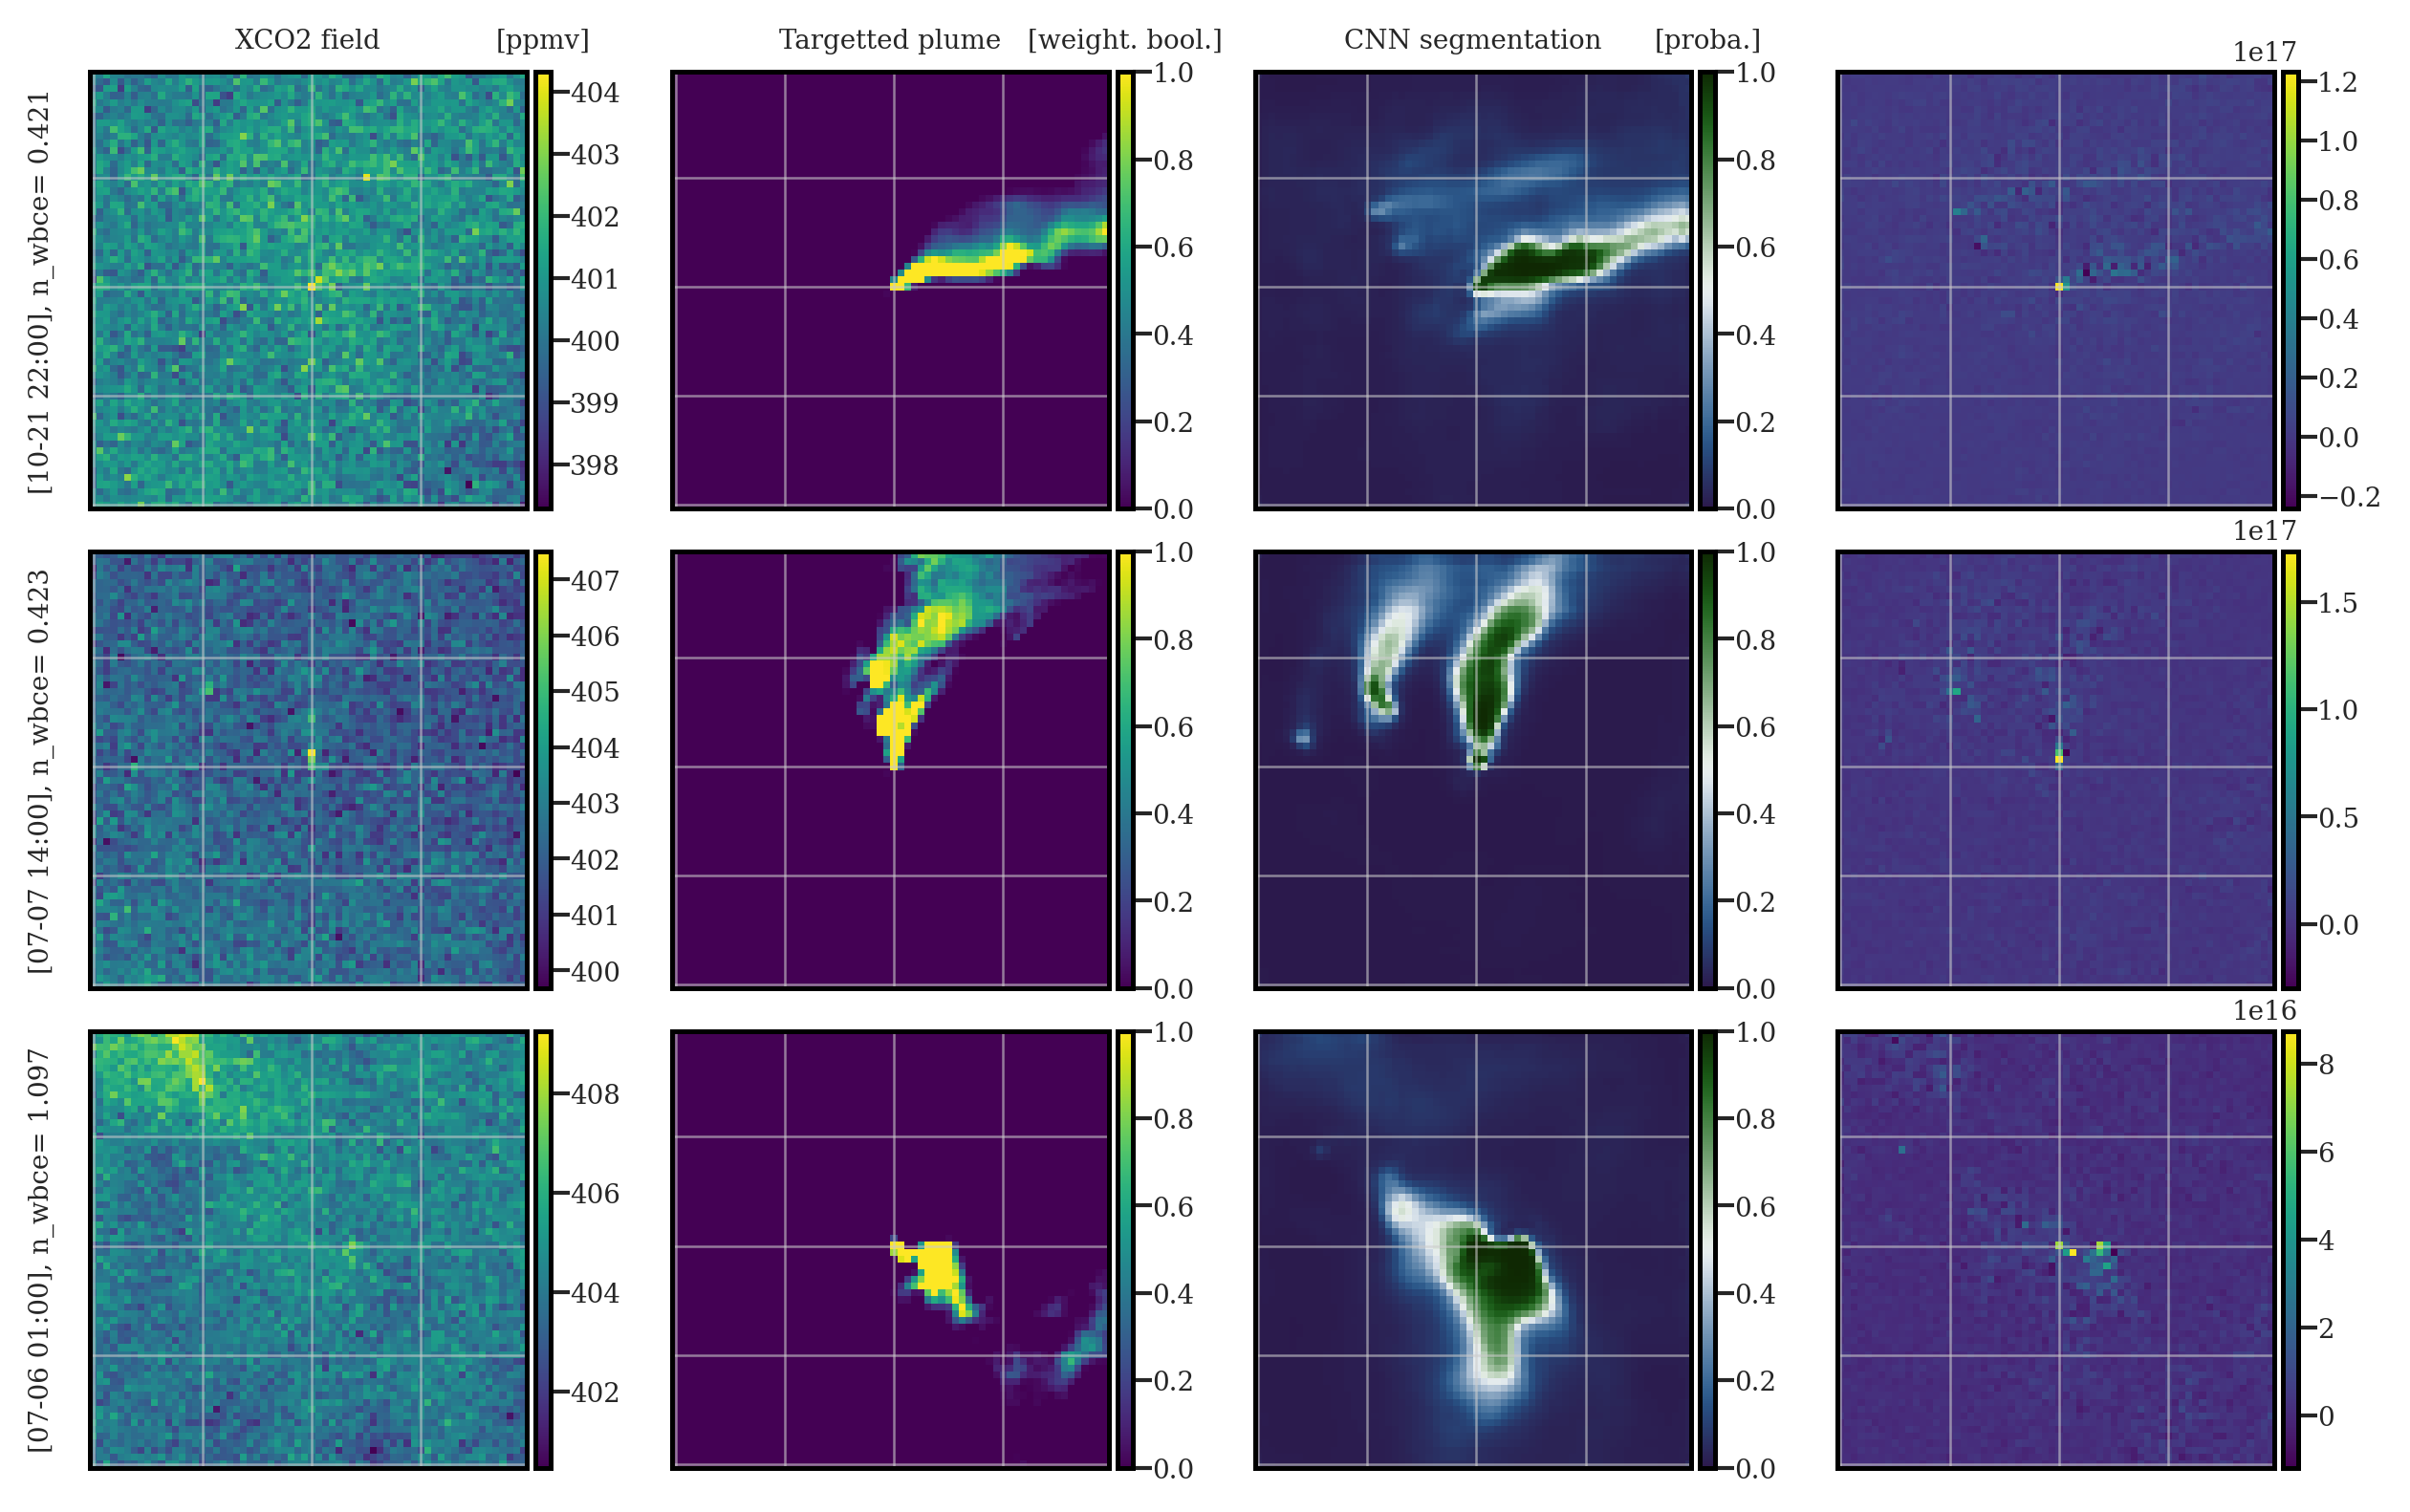

In [51]:
model_eval.plot_segmentation_examples(data, nwbce, model, no2=True)